In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon
from shapely.wkt import loads
import numpy as np
import torch
import os
from netCDF4 import Dataset, num2date, date2num
import matplotlib.pyplot as plt
import scipy

Open up temperature data with NetCDF4 python library and print out the metadata. 

Full readme for file is available at: https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.08/Release_Notes_CRU_TS_4.08.txt

In [3]:
# NOTE: THESE PREDICTORS AREN'T GOING TO BE USED AS OF NOW ##
file_name = "/Users/alim/Documents/ccai_floods/cru_ts4.08.2011.2020.tmp.dat.nc"
file_id = Dataset(file_name)
#print(file_id.variables)

Grab temperature and time data from netCDF4 file and display one timestamp:

(120, 360, 720)
(120,)


Text(0.5, 1.0, '40861')

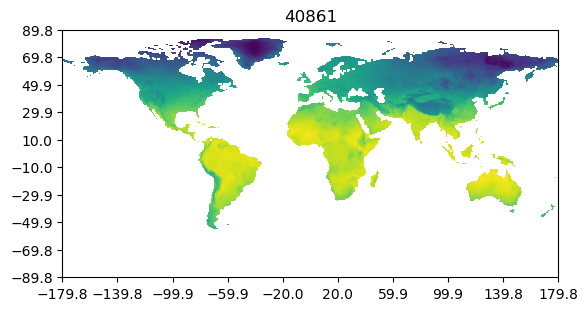

In [4]:
tmp = file_id.variables['tmp'][:]
print(tmp.shape)

flp_img = np.rot90(np.fliplr(tmp[10]), k=2)

time = file_id.variables['time'][:]
print(time.shape)

lon = file_id.variables['lon'][:]

lat = file_id.variables['lat'][:]

lon_plotting = np.linspace(lon[0], lon[-1], 10)
lat_plotting = np.linspace(lat[0], lat[-1], 10)
plt.xticks(lon_plotting)
plt.yticks(lat_plotting)
plt.imshow(flp_img, extent=[lon[0], lon[-1], lat[0], lat[-1]])
plt.title(str(int(time[10])))

Print out Lat and Long values:

In [4]:
print(len(list(lat)))

360


Get flood event ground truth data (https://floodobservatory.colorado.edu/temp/FloodArchive.txt)

In [6]:
print(os.getcwd())
gt = pd.read_csv('/Users/alim/Documents/ccai_floods/gt/FloodArchive.txt', encoding= 'unicode_escape', on_bad_lines='skip', 
                sep= '\t')

/Users/alim/Documents/ccai_floods/flood_prediction


Filter data for just Kenya:

In [7]:
print(gt.columns)

gt_kenya = gt[gt['Country'] == "Kenya"]
print(gt_kenya.shape)
gt_kenya = gt_kenya.reset_index(drop=True)

#print(gt_kenya)

Index(['ID', 'GlideNumber', 'Country', 'OtherCountry', 'long', 'lat', 'Area',
       'Began', 'Ended', 'Validation', 'Dead', 'Displaced', 'MainCause',
       'Severity'],
      dtype='object')
(55, 14)


Text(0.5, 1.0, 'Distribution of Flood Events in Kenya over time - Starting')

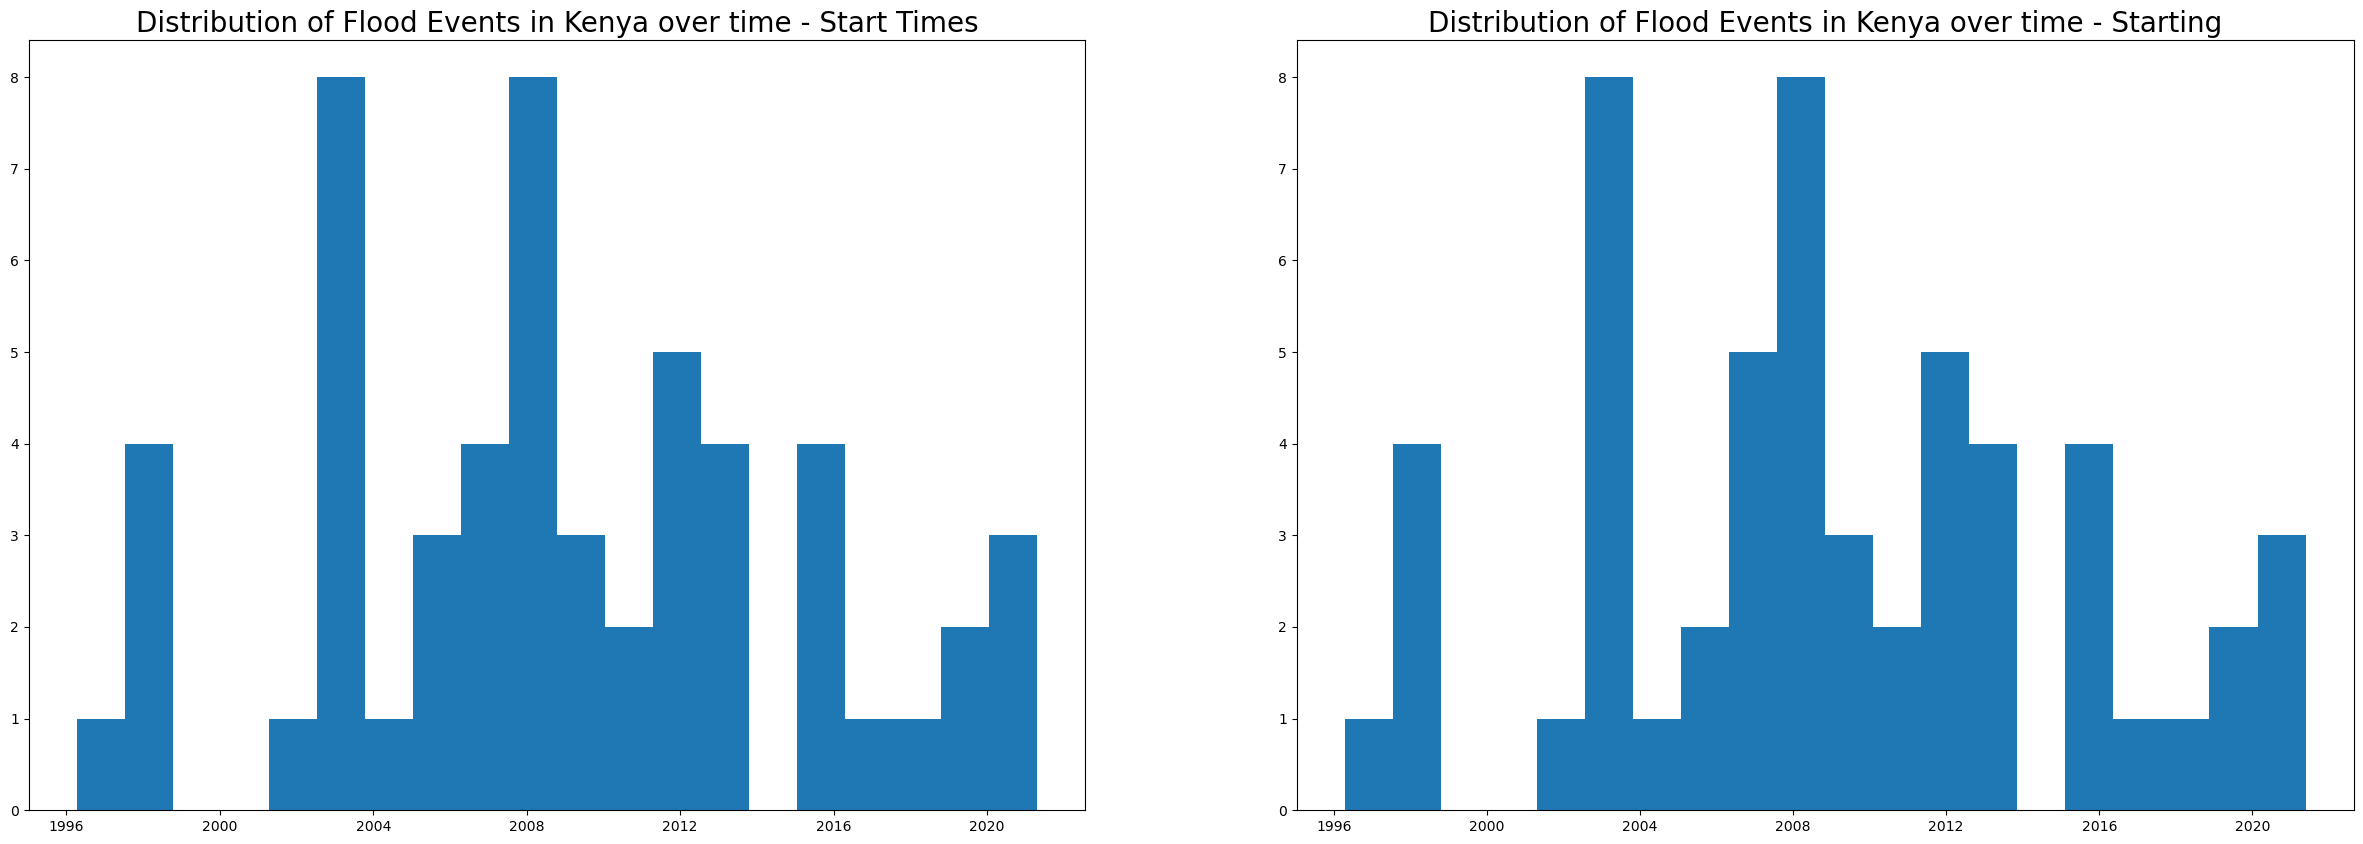

In [8]:
#update began and end date columns to date time format:
gt_kenya['Began'] = pd.to_datetime(gt_kenya['Began'], format='%Y%m%d')
gt_kenya['Ended'] = pd.to_datetime(gt_kenya['Ended'], format='%Y%m%d')



#print(gt_kenya['Began'])
#print(gt_kenya['Ended'])

fig, ax = plt.subplots(1,2, figsize=(30,10))

ax[0].hist(gt_kenya['Began'], bins=20)
ax[1].hist(gt_kenya['Ended'], bins=20)

ax[0].set_title("Distribution of Flood Events in Kenya over time - Start Times", fontsize=20)
ax[1].set_title("Distribution of Flood Events in Kenya over time - Starting", fontsize=20)


In [9]:
# start and end analysis:
days = np.abs(gt_kenya['Began'] - gt_kenya['Ended'])
running_total = 0
for event in days:
    #print(type(event))
    days_as_decimal = event.total_seconds() / (24 * 60 * 60)
    #print(days_as_decimal)
    running_total+=( days_as_decimal * 8)
    #print(running_total)
#print(running_total)

Now, visualize spatially:

(1, 1) Index(['geometry'], dtype='object')
0    MULTIPOLYGON (((33.90983 0.09872, 33.91270 0.1...
Name: geometry, dtype: geometry


<Figure size 2000x2000 with 0 Axes>

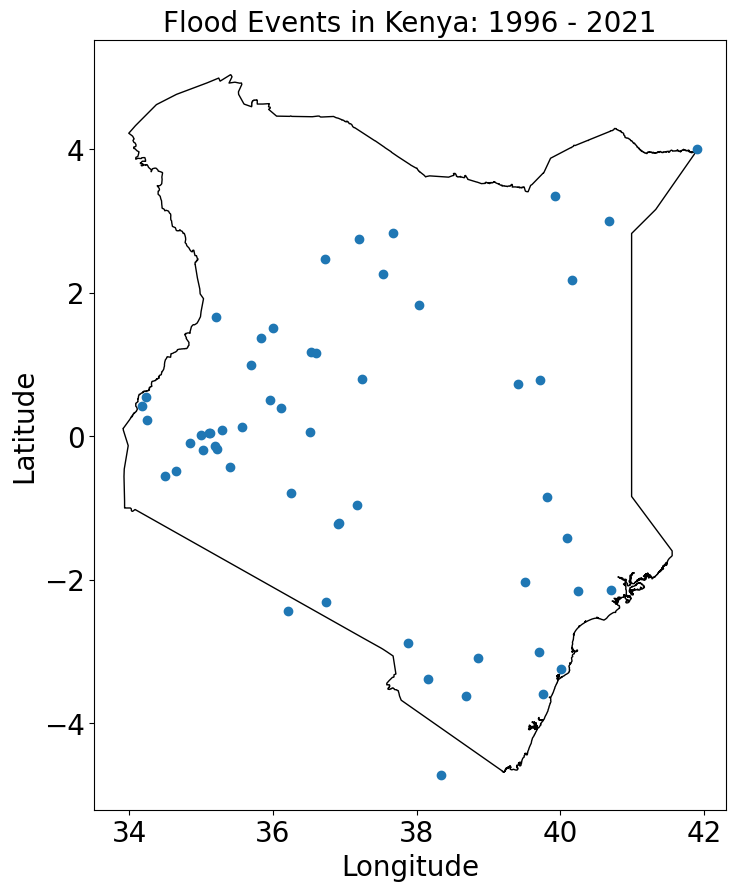

In [10]:
#load kenya shapefile:
shpfile_path = '/Users/alim/Documents/ccai_floods/kenya_shp/kenya_shp.shp' # need an shx file in the kenya_shp directory as well. 

kenya_shp = gpd.read_file(shpfile_path)
print(kenya_shp.shape, kenya_shp.columns)
print(kenya_shp['geometry'])

plt.figure(figsize=(20, 20))


kenya_shp.plot(facecolor="none", figsize=(10,10))


plt.scatter(x=gt_kenya['long'],y= gt_kenya['lat'])
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)
plt.title("Flood Events in Kenya: 1996 - 2021", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('kenya_map.jpg', dpi = 1000)

# for i, row in gt_kenya.iterrows():
#     plt.annotate(row['Began'].strftime('%Y-%m'), (row['long'], row['lat']), 
#                  textcoords="offset points", xytext=(0,10), ha='center')


Now that we have an events dataset, we need to sample them to a grid. Grid should be 0.25 by 0.25

In [13]:
import xarray as xr

nc_era5 = Dataset('./data/features/download_1996.nc')
#print(nc_era5)

lon_era5 = nc_era5.variables['longitude'][:]

lat_era5 = nc_era5.variables['latitude'][:]

time_era5 = nc_era5.variables['time'][:]

#print(len(lon_era5))

#print(len(lat_era5))

#print(len(time_era5))
# generate a list of all the combinations of lat and long. 
# this can be done by taking the cartesian product of the list of longs and list of lats. (A x B , where x is the cartesian product, will
# generate the set of all ordered pairs (a,b) where a is in set A and b is in set B).

import itertools

cartesian_product_lon_lat = np.array(list(itertools.product(lat_era5, lon_era5)))

# print(type(cartesian_product_lon_lat))
# print(cartesian_product_lon_lat)
# print(len(lat_era5) * len(lon_era5))
# print(len(cartesian_product_lon_lat))


In [14]:
def find_closest_vector(source, target):
    """
    Target needs to be in np.array([lat, long]) format
    """
    # Calculate the Euclidean distance between each row in the source matrix and the target vector
    distances = np.linalg.norm(source - target, axis=1)
    # Find the index of the minimum distance
    min_index = np.argmin(distances)
    
    # Return the closest vector and its index
    return source[min_index], min_index

# Example usage
source = cartesian_product_lon_lat  # 20x2 matrix with random values
target = np.array([0, 40.4])   # 1x2 target vector

closest_vector, index = find_closest_vector(source=cartesian_product_lon_lat, target=target)
print(f"Closest vector: {closest_vector}")
print(f"Index of closest vector: {index}")



Closest vector: [ 0.  40.5]
Index of closest vector: 726


In [15]:
def convert_coordinates_to_2d_index(coordinates, range_lon, range_lat, verbose=False):
    """
    Given a range of latitudes and longitudes with a given spacing, this function takes coordinates in the (long, lat) (note 
    that long, lat is the same as row, col order) and returns a 2d index (0 based indexing) so that downstream code can plot 
    something based on this indexing system. 
    """
    idx_col = np.argmin(np.abs(range_lon - coordinates[1]))

    idx_row = np.argmin(np.abs(range_lat - coordinates[0]))
    if verbose:
        print(idx_row, idx_col)
        print(range_lon, range_lat)

    return (idx_row, idx_col)

convert_coordinates_to_2d_index(coordinates = np.array([5, 42]), range_lon = lon_era5, range_lat = lat_era5)

(0, 32)

In [16]:
# create an empty array which is the size of the spatial dimension of the data in ERA5.
target_cube = np.zeros((len(lat_era5), len(lon_era5)))
print(target_cube.shape)

# for each flood event in the gt_kenya, find the lat / long in the ERA5 grid system that is closest. 
# then, convert that lat / long in the ERA5 grid system to a 2d index (row, col).
# add 1 to the np_empty array - this will signify a GT event in that cell.

def append_flood_observation(target_cube, ground_truth_df):
    # get event longs, lats from ground_truth_df:
    temp_lon, temp_lat = ground_truth_df['long'], ground_truth_df['lat']
    #print(temp_lon, temp_lat)

    # for each long, lat, use the find_closest_vector_2d function to find the closest long/lat in the ERA5 grid system
    for obs_coordinates in zip(temp_lat, temp_lon):
        # use find_closest_vector_2d function
        closest_vector, index = find_closest_vector(cartesian_product_lon_lat, obs_coordinates)
        # print(f"Closest vector:{closest_vector}")
        # print(f"Index of closest vector: {index}")
        # convert that closest vector to a 2d zero based indexing system. 
        temp_raster_idx = convert_coordinates_to_2d_index(closest_vector, range_lon = lon_era5, range_lat = lat_era5)
        temp_row_idx, temp_col_idx = temp_raster_idx[0], temp_raster_idx[1]
        # add 1 to the target_cube
        target_cube[temp_row_idx, temp_col_idx]+= 1

    return target_cube
target_cube = append_flood_observation(target_cube, ground_truth_df=gt_kenya)

(41, 35)


[ 4  2  0 -2 -4]


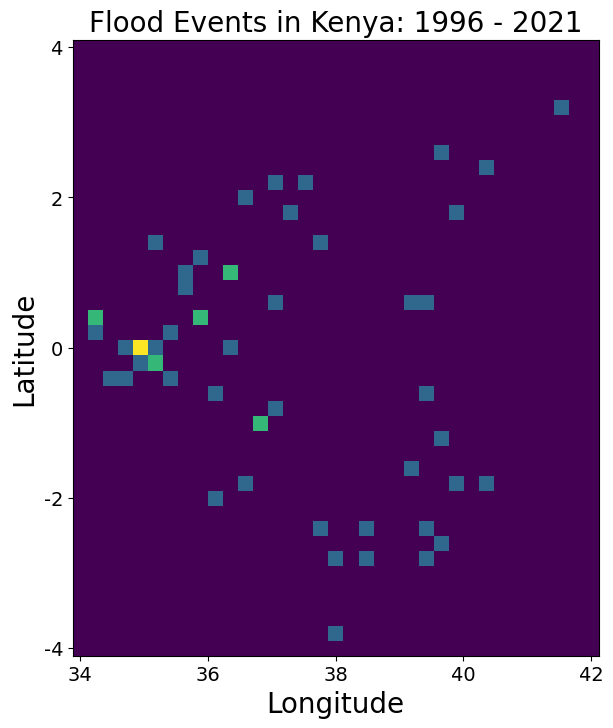

In [17]:
plt.figure(figsize=(8, 8))

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)
plt.title("Flood Events in Kenya: 1996 - 2021", fontsize=20)

y = np.arange(0,41, 1)
x = np.arange(0,35, 1)

# my_xticks = np.arange(34, 42.75, 0.25)
# my_yticks = np.arange(-5, 5.25, 0.25)

# Latitude and Longitude ranges with every 2 degrees
my_xticks = np.arange(34, 43, 2)  # Longitude from 34 to 42 with a step of 2 degrees
my_yticks = np.flip(np.arange(-4, 6, 2) )  # Latitude from -5 to 5 with a step of 2 degrees
print(my_yticks)

# Set the ticks to show every 2 degrees
plt.xticks(np.linspace(0, 34, len(my_xticks)), my_xticks)
plt.yticks(np.linspace(0, 40, len(my_yticks)), my_yticks)
# plt.xticks(x, my_xticks)
# plt.yticks(y, my_yticks)


plt.tick_params(axis='both', which='major', labelsize=14)


plt.imshow(target_cube)

plt.savefig('aggregated.jpg', dpi=1000)





In [18]:
# now, build spatial_temporal cube.
import cftime

time = nc_era5.variables['time']

time_cube = np.zeros((len(time_era5), len(lat_era5), len(lon_era5))) # T x H x W

dates = num2date(time, time.units, time.calendar)


def append_flood_observations(target_time_cube, ground_truth_df, verbose=False):

    for (t_start, t_end, lat, long) in zip(ground_truth_df['Began'], ground_truth_df['Ended'], ground_truth_df['lat'], ground_truth_df['long']):
        #print(t_start, 'this is t_start')
        #print(type(t_start))
        numdate_began = date2num(t_start, units=time.units, has_year_zero=False, calendar='gregorian')
        numdate_ended = date2num(t_end, units=time.units, has_year_zero=False, calendar='gregorian')
    
        # get the nearest time indices in cube
        # first: the begining time index:
        start_time_idx = np.argmin(np.abs(numdate_began - time_era5))
    
        # second: the ending time index
        end_time_idx = np.argmin(np.abs(numdate_ended - time_era5))
        #print('this is start and end', start_time_idx, end_time_idx)
    
        # now, get the lat and long of the flood observation:
        #print(lat, long)
        temp_obs_coord = np.array([lat, long])
        # now, retrieve the nearest lat and long coordinate in the gridding system:
        closest_vector, _ = find_closest_vector(source=cartesian_product_lon_lat, target=temp_obs_coord)
        #print(f"Closest vector: {closest_vector}")
    
        # now, convert the nearest lat and long vector to a 2d index so the time cube can be filled in.
        idx_row, idx_col = convert_coordinates_to_2d_index(coordinates = closest_vector, range_lon = lon_era5, range_lat = lat_era5)    
        #print(idx_row, idx_col)

        target_time_cube[start_time_idx : end_time_idx, idx_row, idx_col] += 1

    return time_cube
        
time_cube = append_flood_observations(target_time_cube = time_cube, ground_truth_df = gt_kenya, verbose=False)


print(np.sum(time_cube))

24.0


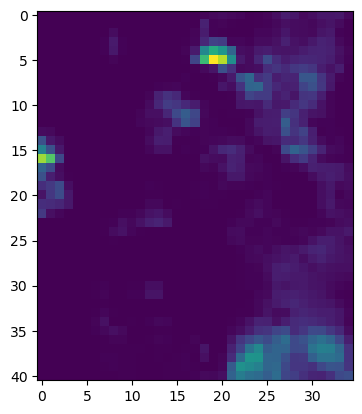

In [19]:
#plt.imshow(time_cube[785])

#print(np.where(time_cube == 1))

# visualize precip over row 22 col 3:
#print(nc_era5.variables['tp'])

plt.imshow(nc_era5.variables['tp'][785])

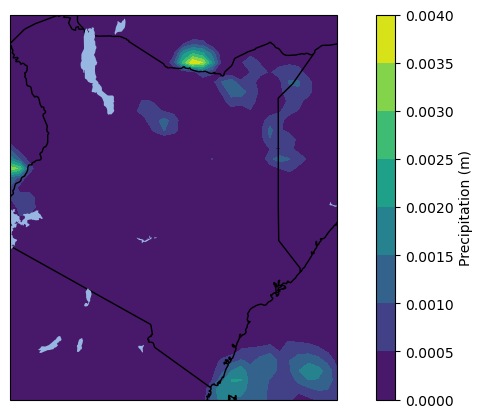

In [272]:
# plot map of precipitation from one time step:

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from netCDF4 import Dataset

# Open your netCDF file
temp_dataset = Dataset('download.nc')

# Extract the data you want to plot
precipt_test = temp_dataset.variables['tp'][785, :, :]  # Adjust indices as needed
lons_test = temp_dataset.variables['longitude'][:]
lats_test = temp_dataset.variables['latitude'][:]

# Create a plot with a Cartopy map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add a background map of the world
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.LAKES)
# Plot the data
plt.contourf(lons_test, lats_test, precipt_test, transform=ccrs.PlateCarree(), cmap='viridis')

# Add color bar
plt.colorbar(label='Precipitation (m)')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Leaf Area Index - Low Vegetation')

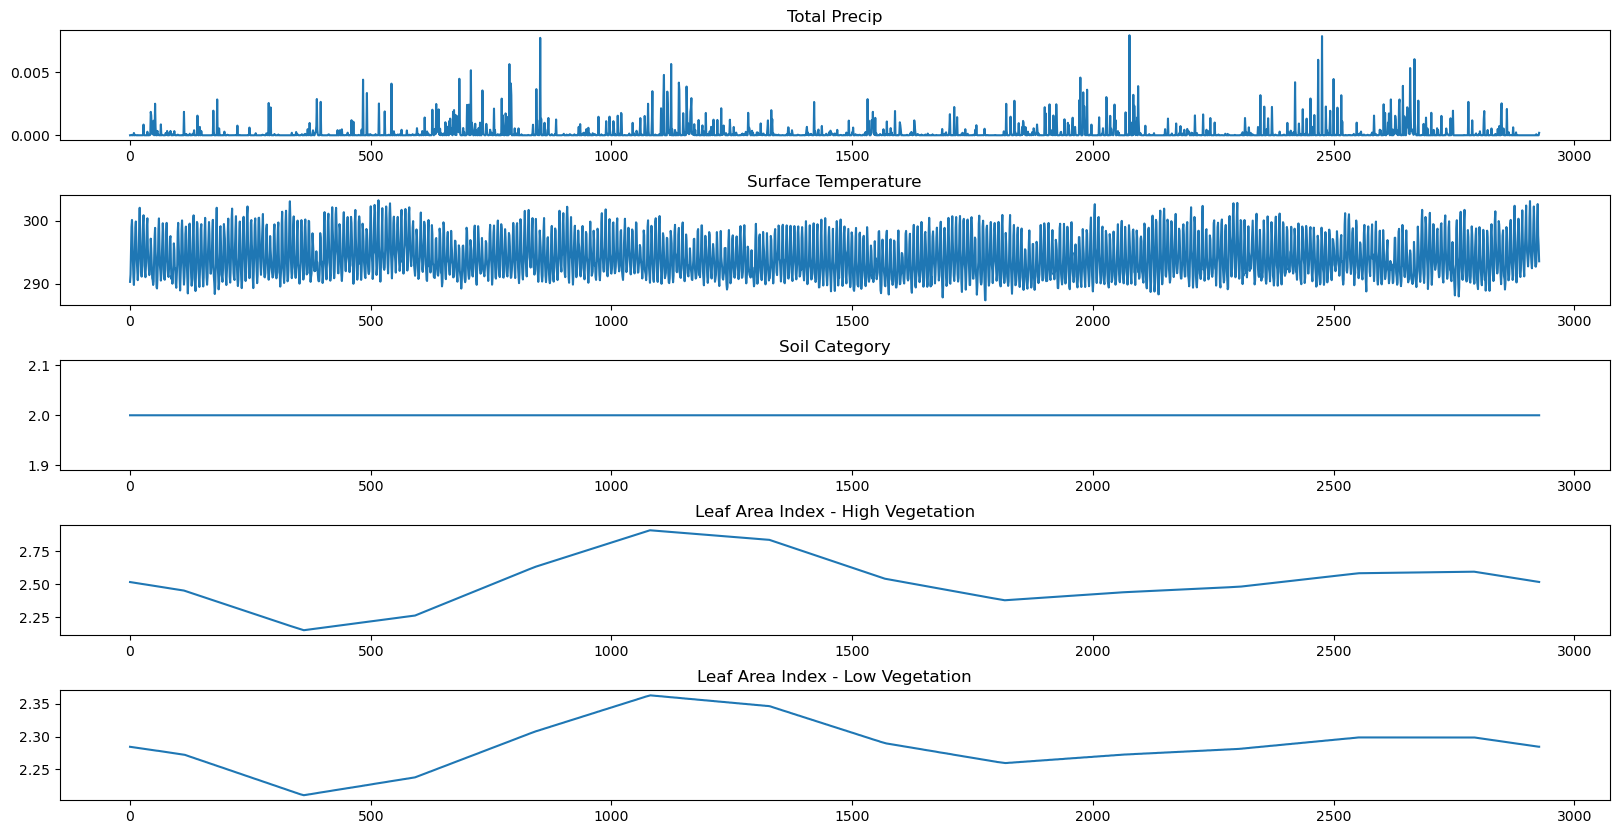

In [292]:
# plot precipt over time at spatial index row 22 col 3 (there was a flood event there in the year of data we have)

fig, ax = plt.subplots(5,1, figsize=(20,10))
fig.subplots_adjust(hspace=0.5, wspace=0)
ax[0].plot(temp_dataset.variables['tp'][:, 22, 3])
ax[0].set_title('Total Precip')

ax[1].plot(temp_dataset.variables['t2m'][:, 22, 3])
ax[1].set_title('Surface Temperature')

ax[2].plot(temp_dataset.variables['slt'][:, 22, 3])
ax[2].set_title("Soil Category")

ax[3].plot(temp_dataset.variables['lai_hv'][:, 22, 3])
ax[3].set_title("Leaf Area Index - High Vegetation")

ax[4].plot(temp_dataset.variables['lai_lv'][:, 22, 3])
ax[4].set_title("Leaf Area Index - Low Vegetation")